In [1]:
%pylab --no-import-all inline

Populating the interactive namespace from numpy and matplotlib


# Eigenvectors and biplots over time

In [2]:
import os
import sys

import pandas as pd
import seaborn as sns

# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.pardir, 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport features.build_features
%aimport visualization.visualize
from visualization.visualize import biplot, plot_explained_variance, triplot

In [3]:
# Skip 1996 because the racial resentment questions weren't asked, so it looks funny.
YEARS = [1976, 1988, 1992, 2000, 2004, 2008, 2012, 2016]

In [4]:
DATA_FRAMES_RAW = [pd.read_csv("../data/processed/{year}.csv".format(year=year), index_col=0) for year in YEARS]

In [5]:
DATA_FRAMES = [df.dropna() for df in DATA_FRAMES_RAW]

In [6]:
from functools import reduce
all_variables_list = [set(df.columns) for df in DATA_FRAMES[1:]]
VARIABLES_CONSISTENT_ACROSS_ALL_YEARS = list(reduce(set.intersection, all_variables_list))

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler

# imp = Imputer(strategy='mean')
scl = StandardScaler()
mms = MinMaxScaler(feature_range=(-1, 1))
pca = PCA()
pipeline = Pipeline([
        ('scl', mms),
        #('scl', scl),
        ('pca', pca),
    ])
scaler_pipeline = Pipeline([
#        ('imp', imp),
        ('mms', mms)
        # ('scl', scl),
    ])
pipeline.fit(DATA_FRAMES[1][VARIABLES_CONSISTENT_ACROSS_ALL_YEARS])
scaler_pipeline.fit(DATA_FRAMES[1][VARIABLES_CONSISTENT_ACROSS_ALL_YEARS])

Pipeline(steps=[('mms', MinMaxScaler(copy=True, feature_range=(-1, 1)))])

In [8]:
pcas = [pipeline.transform(df[VARIABLES_CONSISTENT_ACROSS_ALL_YEARS]) for df in DATA_FRAMES[1:]]
scaled = [scaler_pipeline.transform(df[VARIABLES_CONSISTENT_ACROSS_ALL_YEARS]) for df in DATA_FRAMES[1:]]
scaled = [pd.DataFrame(arr, columns=VARIABLES_CONSISTENT_ACROSS_ALL_YEARS) for arr in scaled]

In [9]:
for df, year in zip(scaled, YEARS[1:]):
    biplot(pca, df, title="{} Survey on {} Axes".format(year, YEARS[1]), color=df.PartyID)

In [10]:
pipeline = Pipeline([
#        ('imp', imp),
        ('scl', scl),
        ('pca', pca),
    ])
scaler_pipeline = Pipeline([
#        ('imp', imp),
        ('scl', scl),
    ])

evrs = []
for year, df in zip(YEARS[1:], DATA_FRAMES[1:]):
    pipeline.fit_transform(df)
    evrs.append(pca.explained_variance_ratio_)

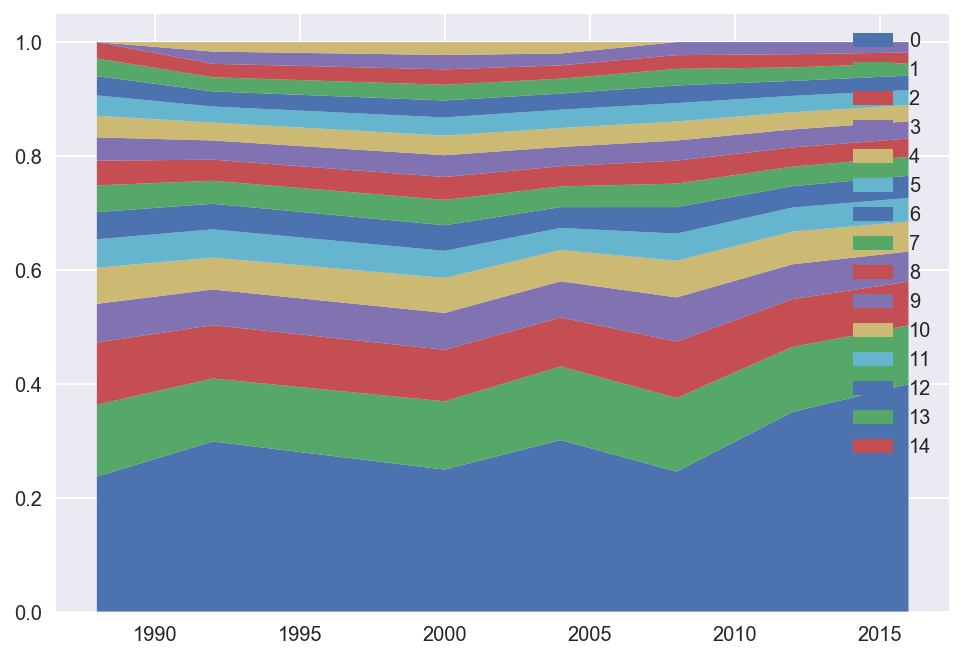

In [11]:
from itertools import zip_longest
plt.stackplot(YEARS[1:], list(zip_longest(*evrs, fillvalue=0)), labels=list(range(len(evrs[0]))))
# Skip YEARS[0] because there are 6 questions instead of 15-16, so it's not representative.
plt.legend()

In [12]:
evs = []
for year, df in zip(YEARS, DATA_FRAMES):
    pipeline.fit_transform(df)
    evs.append(pca.explained_variance_)
evs = np.asarray(list(zip_longest(*evs, fillvalue=0))).T
np.sum(evs > 1, axis=1)

array([2, 4, 4, 5, 4, 5, 3, 3])

In [13]:
sns.set_palette("Set1", 10, .75)

/Users/Arya/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



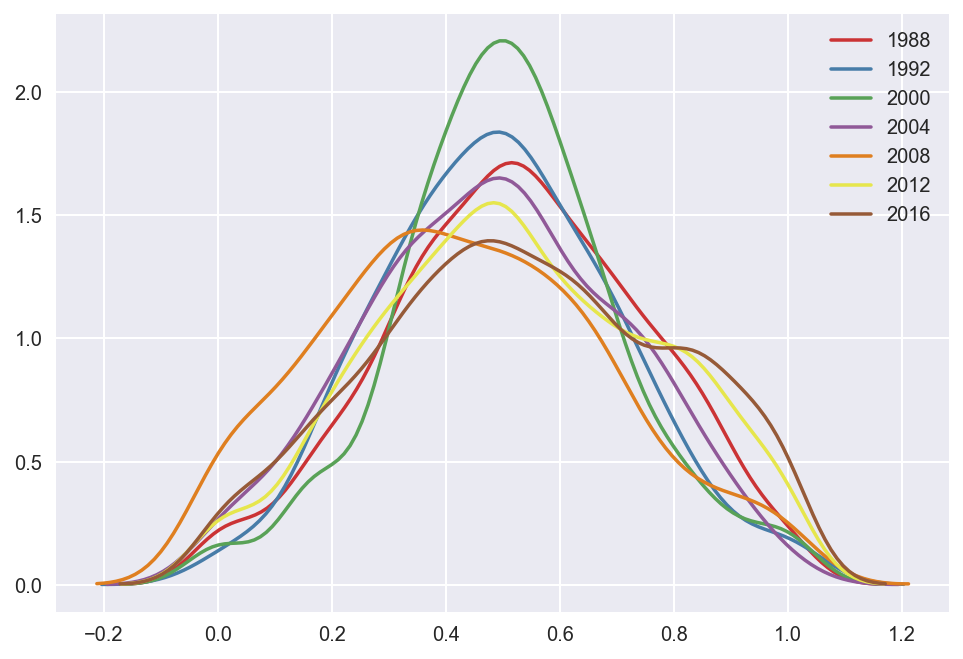

In [14]:
from sklearn.preprocessing import MinMaxScaler

for year, df in zip(YEARS[1:], DATA_FRAMES[1:]):
    df = pd.DataFrame(MinMaxScaler().fit_transform(df.dropna()), columns=df.columns)
    df_econ = (df.NationalHealthInsurance + df.StandardOfLiving + df.ServicesVsSpending) / 3
    sns.kdeplot(df_econ, label = str(year))